# Experimenting with Resolution

In [1]:
# Additional python packages
import os, urllib, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from functions import polar_coord, get_classes, get_wrinkle_class, threshold_image, count_spokes # Our functions 

In [2]:
def load_images(file_list_or_directory,size=(1000,1000)):
    """
    file_list_or_directory:: (string, list, pd.core.series)::
                            you can give a list of full filepaths (using 'filepath' column from get data function dataframe)
                            OR a string to specify diectory
    returns: array of image arrays
    """
    images = []
    
    if type(file_list_or_directory) == str:
        for root, dirs, files in os.walk(file_list_or_directory, topdown=True):
            for name in files:
                mypath = os.path.join(root,name)
                img = Image.open(mypath)
                img = img.resize(size)
#                 arr = np.array(img).astype('uint8')
                images.append(img)
    else:
        for file in file_list_or_directory:
            img = Image.open(file)
            img = img.resize(size)
#             arr = np.array(img).astype('uint8')
            images.append(img)
    return images

def get_data_from_filenames(basepath):
    """
    uses file structure and filename to extract relevant information.
    basepath:: the relative directory to scan for images. basepath must contain a (sub-)directory called 'Images'
    returns: dataframe containing information from filenames
    """
    full_data = []
    for root, dirs, files in os.walk(basepath, topdown=True):
        for name in files:
            data = name.split(".")[0]
            data = data.split("_")
            method = root.split("/")[root.split("/").index("Images") + 1]
            data.insert(0,method)            #add method from directory name to data
            if method == 'Scanner':
                if len(data) < 5:            # make all data consistent length
                    data.append("-")
                if data[4].isdigit():
                    data.insert(4,"-")       # some filenames include background color (W or B). This accounts for missing values.
                if len(data) == 5:
                    data.append('0')         # some filepaths have "_1" or "_2" at the end. This adds "0" for missing values. 
            data[3] = int(data[3][1])

            if method == 'Keyence':          # images in Keyence directory had simpler format. Adding NAs for data consistency,
                data.append("NA")
                data.append("NA")

            data.append(os.path.join(root,name))
            full_data.append(data)
    return pd.DataFrame(full_data,columns=['method','genotype','resolution','day','background_color','img_num??','filepath'])

## Process Images


First threshold each image pixel values.

Then get_wrinkle_class with 2 clusters to find the structure

In [3]:
images = load_images('Images/test')
image_data = get_data_from_filenames('Images/test')

In [9]:
f_images = []
for img in images:
    img = threshold_image(img)
    _,wrinkle_class = get_wrinkle_class(img, n_clusters=2)
    f_images.append(wrinkle_class)

/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



Use the count_spokes function to convert to polar, find edges, and count horizontal lines. 

If there are any horizontl lines found, predict "phz"

In [13]:
predictions = []
for img in f_images:
    if count_spokes(img) > 0:
        predictions.append('phz')
    else:
        predictions.append('WT')

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in int_scalars



## Check Accuracy

In [52]:
image_data['prediction'] = predictions
image_data['correct?'] = np.where(image_data['genotype']==image_data['prediction'],True, False)
wrong_predictions = image_data[image_data['correct?']==False]
wrong_predictions = wrong_predictions.reset_index()
wrong_images = load_images(wrong_predictions['filepath'])

accuracy = np.round(((len(images)-len(wrong_images))/len(images))*100,2)
print( "Accuracy: %s " %accuracy)

Accuracy: 95.83 


## See which images had false predictions

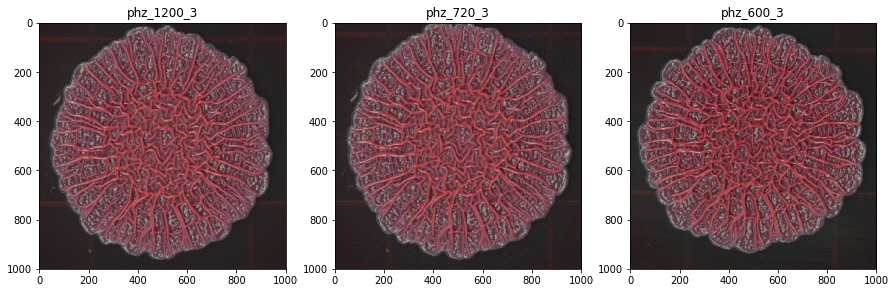

In [45]:
w = 15
h = 15
fig = plt.figure(figsize=(w,h))
c = 3
r = int(np.ceil(len(wrong_images)/3))
for i in range(0,len(wrong_images)):
    img = wrong_images[i]
    fig.add_subplot(r, c, i+1)
    plt.imshow(img)
    plt.title(wrong_predictions['genotype'][i] + '_' + wrong_predictions['resolution'][i]+"_"+wrong_predictions['img_num??'][i])
fig.subplots_adjust(hspace=.5)
plt.show()